In [2]:
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PlotFuncs import *
from LabFuncs import *
from Params import *
from HaloFuncs import *
from scipy.stats import norm
import pandas

import cmocean

# Load shards
df = pandas.read_csv('../data/FitShards_red.csv')
names = df.group_id
nshards = size(names)
velocities = zeros(shape=(nshards,3))
dispersions = zeros(shape=(nshards,3))
velocities[0:(nshards),0] = df.vx # stream velocities
velocities[0:(nshards),1] = df.vy
velocities[0:(nshards),2] = df.vz
dispersions[0:(nshards),0] = df.sigx # dispersion tensors
dispersions[0:(nshards),1] = df.sigy
dispersions[0:(nshards),2] = df.sigz
pops = df.population
Psun = df.Psun
weights = ShardsWeights(names,pops,Psun)

# Halo params
HaloModel = SHMpp
v0 = HaloModel.RotationSpeed
v_esc = HaloModel.EscapeSpeed
sig_beta = HaloModel.SausageDispersionTensor
sig_iso = array([1.0,1.0,1.0])*v0/sqrt(2.0)
day = 67.0 

In [17]:
from WIMPFuncs import *


n = 100
nn = int(n*n/2)
ph = linspace(0, 2*pi, n)
th = linspace(-pi/2, pi/2, int(n/2))
PH, TH = meshgrid(ph,th)
X = cos(PH)*cos(TH)
Y = -sin(PH)*cos(TH)
Z = -sin(TH)
ii = 0
q = zeros(shape=(nn,3))
for i in range(0,int(n/2)):
    for j in range(0,n):
        q[ii,:] = array([X[i,j],Y[i,j],Z[i,j]])
        ii = ii+1

# Benchmark
ne = 100
nbins = 3
E = zeros(shape=(nbins,ne))
E[0,:] = linspace(1.0,5.0,ne)
E[1,:] = linspace(5.0,10.0,ne)
E[2,:] = linspace(10.0,20.0,ne)

m_chi = 100.0
sigma_p = 1.0e-46
A = F19.MassNumber
eta = 0.2

# Radon transform and rate
dR_smooth = zeros(shape=(3,nn))
dR_shards = zeros(shape=(3,nn))
fhat0 = zeros(shape=(nn))
for ibin in range(0,nbins):
    E_r = E[ibin,:]
    v_min = MinimumWIMPSpeed(E_r,A,m_chi)
    for ie in range(0,ne):
        fhat0 = fhat_Isotropic(v_min[ie],-1.0*q,day)
        dR_smooth[ibin,:] += (1-eta)*diffRecoilRate_SI(E_r[ie],fhat0,A,sigma_p,m_chi)
        fhat_saus = fhat_Triaxial(v_min[ie],-1.0*q,day,sig_beta)
        dR_smooth[ibin,:] += eta*diffRecoilRate_SI(E_r[ie],fhat_saus,A,sigma_p,m_chi)
        
        fhat = zeros(shape=(nn))
        for i in range(0,nshards):
            v_s = velocities[i,:]
            sig_s = dispersions[i,:]
            fhat += weights[i]*fhat_Triaxial(v_min[ie],-1.0*q,day,sig_s,v_shift=v_s)
        dR_shards[ibin,:] += diffRecoilRate_SI(E_r[ie],fhat,A,sigma_p,m_chi)
    print('bin =',ibin)

    

# Convert list into Mollweide map
dR_map_smooth = zeros(shape=(int(n/2),n,3))
dR_map_shards = zeros(shape=(int(n/2),n,3))
for ibin in range(0,3):
    ii = 0
    for i in range(0,int(n/2)):
        for j in range(0,n):
            dR_map_smooth[i,j,ibin] = dR_smooth[ibin,ii]
            dR_map_shards[i,j,ibin] = dR_shards[ibin,ii]
            ii = ii+1
    dR_map_smooth[:,:,ibin] = flipud(dR_map_smooth[:,:,ibin])     
    dR_map_shards[:,:,ibin] = flipud(dR_map_shards[:,:,ibin])  
    

/Users/ciaranohare/Work/Zaragoza/HaloSpin/code/HaloFuncs.py:53: RuntimeWarning: invalid value encountered in double_scalars
  *erfi(v_esc/(sqrt(2)*sigr)*sqrt(beta/(1-beta)))

bin = 0
bin = 1
bin = 2


In [18]:
qq = zeros(shape=(int(n/2),n,3))
ii = 0
for i in range(0,int(n/2)):
    for j in range(0,n):
        qq[i,j,0] = q[ii,0]
        qq[i,j,1] = q[ii,1]
        qq[i,j,2] = q[ii,2]
        ii = ii+1

# Apply angular res.
sig_a = 10*pi/180.0
def angres(q0):
    gamma = q0[0]*qq[:,:,0]+q0[1]*qq[:,:,1]+q0[2]*qq[:,:,2]
    gamma[gamma>1] = 1.0
    gamma[gamma<-1] = -1.0
    gamma = arccos(gamma)
    return exp(-gamma**2.0/(2*sig_a**2.0))

def applyangres(dR_map):
    dR_map_s = zeros(shape=(int(n/2),n,3))
    for ibin in range(0,3):
        for i in range(0,int(n/2)):
            for j in range(0,n):
                K = angres(squeeze(qq[i,j,:]))
                Knorm = trapz(flipud(trapz(K,ph,axis=1)),flipud(sin(th)))
                dR_map_s[i,j,ibin] = trapz(flipud(trapz(K*dR_map[:,:,ibin],ph,axis=1)),flipud(sin(th)))/Knorm
                dR_map_s[i,j,ibin] = trapz(flipud(trapz(K*dR_map[:,:,ibin],ph,axis=1)),flipud(sin(th)))/Knorm

    return dR_map_s
                
dR_map_smooth_s = applyangres(dR_map_smooth)
dR_map_shards_s = applyangres(dR_map_shards)
#dR_map_smooth_s = dR_map_smooth
#dR_map_shards_s = dR_map_shards

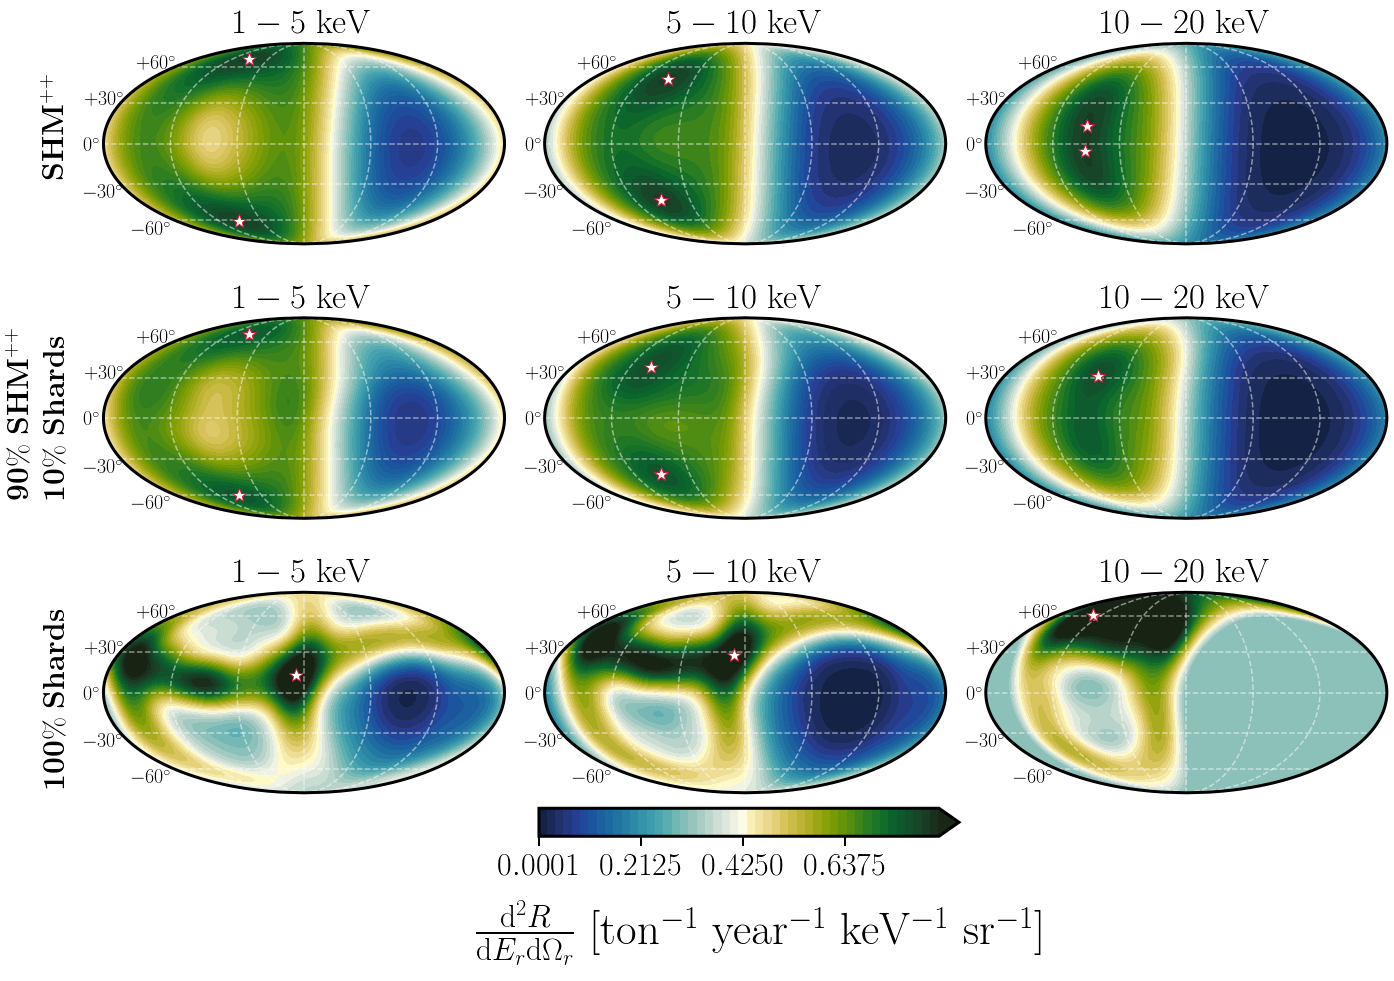

In [65]:
def find2max(dR):
    ni = shape(dR)[0]
    R0 = dR*1.0
    R1 = dR*1.0
    R0[1:int(ni/2),:] = 0.0
    R1[int(ni/2):,:] = 0.0
    imax1 = unravel_index(R0.argmax(), R0.shape)
    imax2 = unravel_index(R1.argmax(), R1.shape)
    return imax1,imax2


def find1max(dR):
    imax1 = unravel_index(dR.argmax(), dR.shape)
    return imax1



######
fig, axarr = plt.subplots(3, 3,figsize=(23,15))
gs = gridspec.GridSpec(3, 3)
gs.update(wspace=0.1,hspace=0.03)

cmap = cmocean.cm.delta
tit = [r'$1-5$ keV',r'$5-10$ keV',r'$10-20$ keV']

xi = 0.1
dR2 = (1-xi)*dR_map_smooth_s+xi*dR_map_shards_s

cmin = amin(dR_map_shards_s)
cmax = around(amax(dR_map_shards_s),1)*0.85

nlevels = 50
tfs = 20

titfontsize = 35

ms = 15

for ibin in range(0,3): 
    dR = dR_map_smooth_s[:,:,ibin]*1.0
    ax = plt.subplot(gs[0,ibin],projection=ccrs.Mollweide())
    MollweideMap1(ax,TH,PH,dR,cmin,cmax,nlevels,cmap,tfs,gridlinecolor='w')
    plt.title(tit[ibin],fontsize=titfontsize,y=1.03)
    if ibin==0:
        ax.annotate(r'{\bf SHM}$^{++}$', xy=(-0.15, 0.35), xycoords='axes fraction',fontsize=30,rotation=90)

    imax1,imax2 = find2max(dR)
    ax.plot(ph[imax1[1]]*180/pi,th[imax1[0]]*180/pi,'w*',mec='crimson',mew=1,ms=ms,transform=ccrs.PlateCarree())
    ax.plot(ph[imax2[1]]*180/pi,th[imax2[0]]*180/pi,'w*',mec='crimson',mew=1,ms=ms,transform=ccrs.PlateCarree())

for ibin in range(0,3): 
    dR = dR2[:,:,ibin]*1.0
    ax = plt.subplot(gs[1,ibin],projection=ccrs.Mollweide())
    MollweideMap1(ax,TH,PH,dR,cmin,cmax,nlevels,cmap,tfs,gridlinecolor='w')
    plt.title(tit[ibin],fontsize=titfontsize,y=1.03)
    if ibin==0:
        ax.annotate(r'{\bf 90}\% {\bf SHM}$^{++}$', xy=(-0.24, 0.12), xycoords='axes fraction',fontsize=30,rotation=90)
        ax.annotate(r'{\bf 10}\% {\bf Shards}', xy=(-0.15, 0.12), xycoords='axes fraction',fontsize=30,rotation=90)
    if ibin<2:
        imax1,imax2 = find2max(dR)
        ax.plot(ph[imax1[1]]*180/pi,th[imax1[0]]*180/pi,'w*',mec='crimson',mew=1,ms=ms,transform=ccrs.PlateCarree())
        ax.plot(ph[imax2[1]]*180/pi,th[imax2[0]]*180/pi,'w*',mec='crimson',mew=1,ms=ms,transform=ccrs.PlateCarree())
    else:
        imax1 = find1max(dR)
        ax.plot(ph[imax1[1]]*180/pi,th[imax1[0]]*180/pi,'w*',mec='crimson',mew=1,ms=ms,transform=ccrs.PlateCarree())


for ibin in range(0,3):
    dR = dR_map_shards_s[:,:,ibin]*1.0
    ax = plt.subplot(gs[2,ibin],projection=ccrs.Mollweide())
    MollweideMap1(ax,TH,PH,dR,cmin,cmax,nlevels,cmap,tfs,gridlinecolor='w')
    plt.title(tit[ibin],fontsize=titfontsize,y=1.03)
    if ibin==0:
        ax.annotate(r'{\bf 100}\% {\bf Shards}', xy=(-0.15, 0.05), xycoords='axes fraction',fontsize=30,rotation=90)
    imax1 = find1max(dR)
    ax.plot(ph[imax1[1]]*180/pi,th[imax1[0]]*180/pi,'w*',mec='crimson',mew=1,ms=ms,transform=ccrs.PlateCarree())

# # Custom colorbar
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cbaxes = inset_axes(ax, width="60%", height="7%", bbox_to_anchor=[370, -240, 700, 400]) 
norm = mpl.colors.Normalize(vmin=cmin,vmax=cmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm,cax=cbaxes,ticks=linspace(cmin,cmax,5),boundaries=linspace(cmin,cmax,nlevels),orientation='horizontal',extend='max')
f = plt.gcf().get_children()
cbar = f[3]
plt.tick_params(which='major',direction='out',width=2,length=10,right=True,top=False,pad=7,labelsize=32)
plt.tick_params(which='minor',direction='out',width=2,length=7,right=True,top=False,labelsize=32)
plt.gcf().text(0.35,-0.004,r'$\frac{\mathrm{d}^2 R}{\mathrm{d}E_r \mathrm{d}\Omega_r}$ [ton$^{-1}$ year$^{-1}$ keV$^{-1}$ sr$^{-1}$]',fontsize=45)


# save figure
plt.show()
pltname = 'Shards_Directional'
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

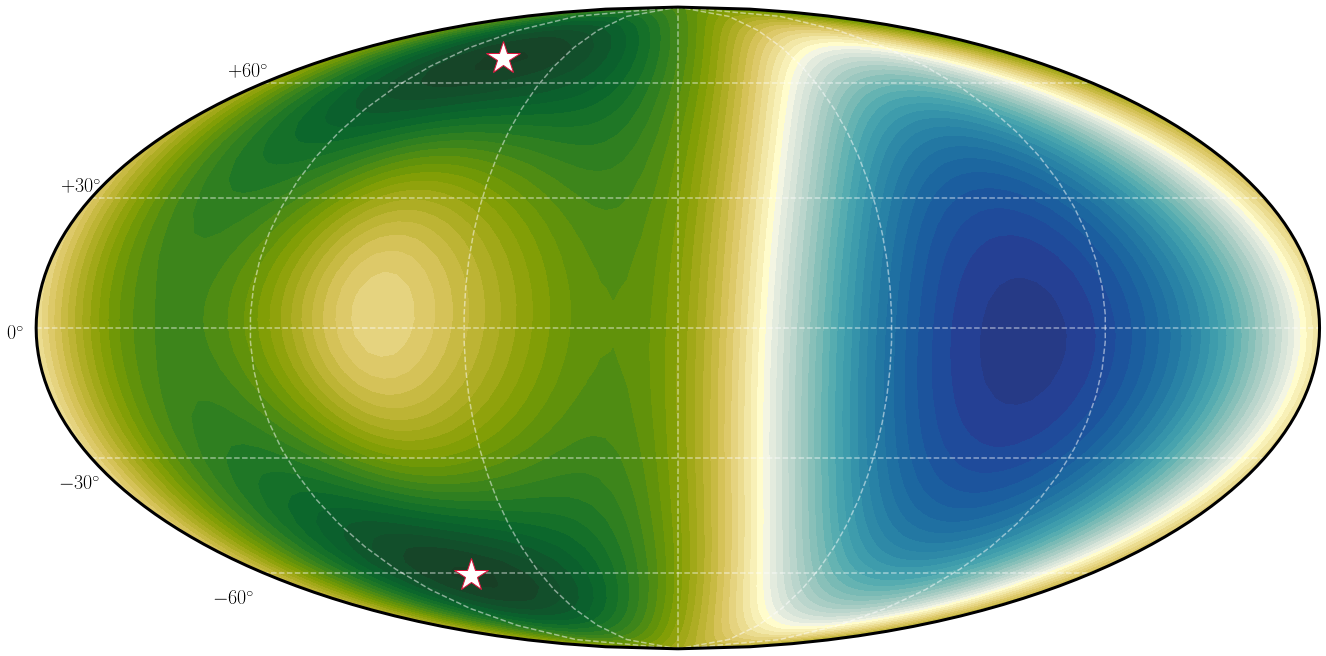

In [61]:
import cartopy.crs as ccrs

def find2max(dR):
    ni = shape(dR)[0]
    R0 = dR*1.0
    R1 = dR*1.0
    R0[1:int(ni/2),:] = 0.0
    R1[int(ni/2):,:] = 0.0
    imax1 = unravel_index(R0.argmax(), R0.shape)
    imax2 = unravel_index(R1.argmax(), R1.shape)
    return imax1,imax2


def find1max(dR):
    imax1 = unravel_index(dR.argmax(), dR.shape)
    return imax1,imax2


fig, axarr = plt.subplots(1, 1,figsize=(23,15))
gs = gridspec.GridSpec(1, 1)

ax = plt.subplot(gs[0],projection=ccrs.Mollweide())
MollweideMap1(ax,TH,PH,dR_map_smooth_s[:,:,0],cmin,cmax,nlevels,cmap,tfs,gridlinecolor='w')


imax1,imax2 = find2max(dR_map_smooth_s[:,:,0])
ax.plot(ph[imax1[1]]*180/pi,th[imax1[0]]*180/pi,'w*',mec='crimson',mew=1,ms=35,transform=ccrs.PlateCarree())
ax.plot(ph[imax2[1]]*180/pi,th[imax2[0]]*180/pi,'w*',mec='crimson',mew=1,ms=35,transform=ccrs.PlateCarree())



In [54]:
print(ph[imax1[1]]*180/pi,th[imax1[0]]*180/pi)

0.0 -90.0


In [44]:
dR = dR_map_smooth_s[:,:,0]
R0 = dR*1.0
R1 = dR*1.0
R0[1:int(ni/2),:] = 0.0
R1[int(ni/2):,:] = 0.0

plt.imshow(R0)

4.696522350821105